# CSCN8020 Q Learning Taxi


The environment we define will contain:
- 500 discrete states
- 6 discrete actions
- Reward structure:
    - -1 per step
    - +20 for correct passenger drop-off
    - -10 for illegal pickup or drop-off

The goal is to learn the optimal policy that maximizes cumulative reward by efficiently transporting passengers.

Legend:
- Agent: Taxi
- Enviornment: Taxi-v3 grid world
- State Space: 500 discrete states
- Action Space: 6 discrete actions
- Policy: ε-greedy
- Value function: Q(s,a)
- Learning Type: Model free, off-policy, Temporal difference

The Q-Learning update rule:
Q(s,a) ← Q(s,a) + α [r + γ max_a' Q(s',a') − Q(s,a)]

Where:
- α = learning rate
- γ  = discount factor
- ε =  exploration factor ( ε-greedy policy)



## 1. Import & Setup

In [110]:
from idlelib.rpc import request_queue

import gymnasium as gym
import numpy as np
import random
import logging
import matplotlib.pyplot as plt
import time

# Setup logging
logger = logging.getLogger("TaxiQLearning")
logger.setLevel(logging.INFO)

# Clear old handlers (important in notebooks)
if logger.hasHandlers():
    logger.handlers.clear()

file_handler = logging.FileHandler("taxi_training.log", mode="w")
formatter = logging.Formatter(
    "%(asctime)s | %(levelname)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# Simulation logger (separate file)
sim_logger = logging.getLogger("TaxiSimulation")
sim_logger.setLevel(logging.INFO)


if sim_logger.hasHandlers():
    sim_logger.handlers.clear()

sim_file_handler = logging.FileHandler("taxi_simulation.log", mode="w")
sim_file_handler.setFormatter(formatter)
sim_logger.addHandler(sim_file_handler)

log_to_file=False

Imports explanation:
- gymnasium: provides Taxi environment for experiment
- numpy: used for Q-table and math operations
- random: used for epsilon-greedy exploration
- logging: used to store metrics into a file that can be used to analyze and compare info
- matplotlib: used for plotting performance curves

The Q-table will be a 500 x 6 matrix
Each row corresponds to a state while each column corresponds to an action.

## 2. Initialize Environment & Analysis

Observation space: 500 states

State encoding:
((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination

Breakdown:
- 25 taxi positions
- 5 passenger locations
- 4 destination locations

Action Space (6 actions):
0: South (Down)
1: North (Up)
2: East (Right)
3: West (Left)
4: Pickup passenger
5: Drop off passenger

Reward Structure:
- -1per step
- +20 successful passenger drop-off
- -10 illegal pickup or drop off

The step penalty encourages shortest-path behavior
The +20 reward propagates backward via bootstrapping which is to say, the agent updates its current state-value estimate based on the estimated value of the previous state. Over multiple episodes the +20 reward is passed backward a step at a time which eventually points directly toward the goal.

In [111]:
env = gym.make("Taxi-v3")

state_size = env.observation_space.n
action_size = env.action_space.n #.n indicates that the environment is using a discrete space and the .n stands for the number and it returns the absolute count of discrete elements within that specific space

print("State Size: ", state_size)
print("Action Size: ", action_size)

State Size:  500
Action Size:  6


## 3. Q-Learning Implementation

We implement tabular Q-Learning:
This means the agent uses a 2D matrix(states as rows, actions as columns) to store expected future rewards, continuously updating these values through experience to learn the best possible action for any given situation

Q-table dimensions
500 x 6

Policy:
ε-greedy

Update:
Q(s,a) += α [ r + γ max Q(s',a') − Q(s,a) ]

The TD error is
δ = r + γ max Q(s',a') − Q(s,a)

If δ > 0 → underestimation
If δ < 0 → overestimation

The algorithm is model-free and off-policy.


In [112]:
def train_q_learning(name, alpha, gamma, epsilon, episodes=5000, log_to_file=False):

    if log_to_file:
        logger.info("="*70)
        logger.info(f"Starting Experiment: {name}")
        logger.info(f"Alpha (Learning Rate): {alpha}")
        logger.info(f"Gamma (Discount Factor): {gamma}")
        logger.info(f"Epsilon (Exploration Rate): {epsilon}")
        logger.info("="*70)

    Q  = np.zeros([state_size, action_size])

    steps_per_episode = []
    rewards_per_episode = []

    for episode in range(episodes):

        state, _ = env.reset()
        done = False
        total_reward = 0
        steps = 0

        while not done:
            #ε-greedy action selection
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            #Q-Update
            Q[state, action] += alpha * (
                reward + gamma * np.max(Q[next_state]) - Q[state, action]
            ) # This line of code adjusts the current q-value byt taking a small step (determined by the learning rate alpha) toward the newly observed reality, which is the immediate reward plus the best possible estimated future value

            state = next_state
            total_reward += reward
            steps += 1

        steps_per_episode.append(steps)
        rewards_per_episode.append(total_reward)


      #Logs training
        if log_to_file and (episode + 1) % 10 == 0:
            logger.info(
                f"Episode {episode+1:4d} | "
                f"Steps: {steps:4d} | "
                f"Reward: {total_reward:6.2f}"
            )


    return Q, steps_per_episode, rewards_per_episode



## 4. Metric Reporting

The following metrics will be reported:
1. Total Episodes
2. Total steps per episode
3. Average return per episode
Each is computed and loged for each experiment

In [113]:
def summarize_results(name, steps, rewards):

    total_episodes = len(rewards)
    avg_return = np.mean(rewards)
    avg_steps = np.mean(steps)

    summary = (       f"\n{'#'*60}\n"
        f"EXPERIMENT: {name}\n"
        f"Total Episodes: {total_episodes}\n"
        f"Average Return: {avg_return:.3f}\n"
        f"Average Steps: {avg_steps:.3f}\n"
        f"{'#'*60}\n"
    )

    print(summary)
    logger.info(summary)





## 5. Base Training run

In [114]:
name = "Base_Run"
alpha = 0.1 #Learning Rate
gamma = 0.9 # Discount Factor
epsilon = 0.1 #Exploration Rate

Q_base, steps_base, rewards_base, = train_q_learning(name, alpha, gamma, epsilon)

summarize_results("Base_Run", steps_base, rewards_base)


############################################################
EXPERIMENT: Base_Run
Total Episodes: 5000
Average Return: -21.435
Average Steps: 30.362
############################################################



## 6. Plot Base Metrics

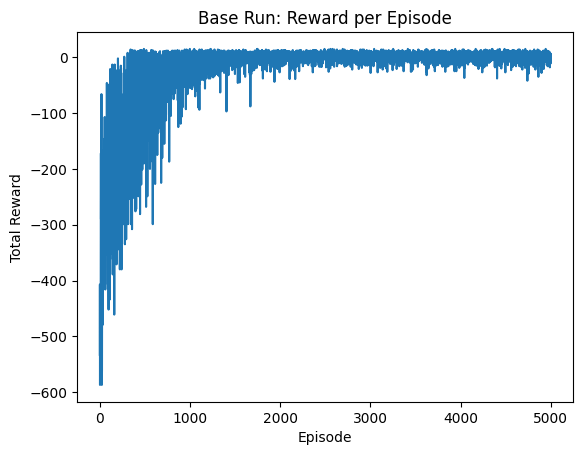

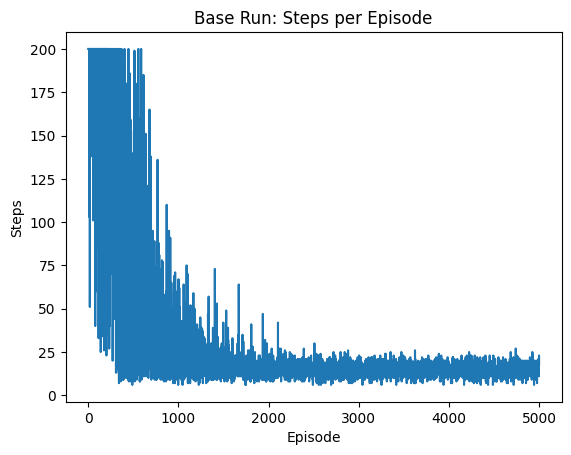

In [115]:
plt.figure()
plt.plot(rewards_base)
plt.title("Base Run: Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()

plt.figure()
plt.plot(steps_base)
plt.title("Base Run: Steps per Episode")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.show()

### 6.1 Plot interpretation

These Two plots show us important things to understand how the base run went.
In the first plot it shows the rewards per episode. You can see that in the earlier episodes the rewards are very low deep into the negatives but around  episode 1500 it starts to converge? And  the rewards become 0 or positive

The second plot shows the amount of steps per episode. Like before the agent takes alot of steps at the starts since its exploring. By the 1500 episode mark it takes much less steps attempting to take the minimal and most optimal steps need

## 7. Hyperparameter Analysis & Learning Rate Experiments (Fixed Exploration)

Learning Rate α:
Small means slower convergence while Large means its faster for convergence but has unstable updates which is to say, the learning rate dictates how much we trust a single new experience vs the previous accumulated historical knowledge.

When its small the Q-value is only updated by a tiny function of the TD error. When its large the agent just aggressively overwrites the past knowledge with whatever just happened which helps it quickly adapt to new information

Discount Factor  γ:
Low means the agent is short sighted(prioritizes immediate rewards) while high means the agent is far-sighted(Prioritizes long term rewards). When the discount factor is close to 0 the agent becomes myopic which means it heavily discounts anything that doesnt happen immediately.

When its high the agent carries so much about rewards in the far future its almost the same as if it's the very next step. In this taxi experiment where we have set +20 drop off rewards and -1-step penalties, it is necessary to have a high discount factor, or it wouldn't endre the string of the penalties required to reach the reward


In [116]:
learning_rates = [0.01, 0.001, 0.2]

lr_results = {}

for lr in learning_rates:
    Q, steps, rewards = train_q_learning(
        name=f"LR_{lr}",
        alpha=lr,
        gamma=0.9,
        epsilon=0.1,
        log_to_file=False
    )

    summarize_results(f"LR_{lr}", steps, rewards)

    lr_results[lr] = {
        "steps": steps,
        "rewards": rewards,
        "avg_return": np.mean(rewards),
        "avg_steps": np.mean(steps),
    }



############################################################
EXPERIMENT: LR_0.01
Total Episodes: 5000
Average Return: -160.954
Average Steps: 127.243
############################################################


############################################################
EXPERIMENT: LR_0.001
Total Episodes: 5000
Average Return: -258.668
Average Steps: 185.445
############################################################


############################################################
EXPERIMENT: LR_0.2
Total Episodes: 5000
Average Return: -11.451
Average Steps: 23.298
############################################################



## 8. Exploration Rate Experiments (Fixed Learning Rate)

In [117]:
exploration_factors = [0.2, 0.3]

epsilon_results = {}

for e in exploration_factors:
     Q, steps, rewards = train_q_learning(
        name=f"EPSILON_{e}",
        alpha=0.1,     # keep alpha fixed
        gamma=0.9, #fixed gamma
        epsilon=e,
         log_to_file=False
    )

     summarize_results(f"EPSILON_{e}", steps, rewards)

     epsilon_results[e] = {
        "steps": steps,
         "rewards": rewards,
         "avg_return": np.mean(rewards),
         "avg_steps": np.mean(steps),
     }


############################################################
EXPERIMENT: EPSILON_0.2
Total Episodes: 5000
Average Return: -32.278
Average Steps: 32.770
############################################################


############################################################
EXPERIMENT: EPSILON_0.3
Total Episodes: 5000
Average Return: -47.327
Average Steps: 35.995
############################################################



## 9. Comparison Plots for Learning Rates (Fixed Exploration)

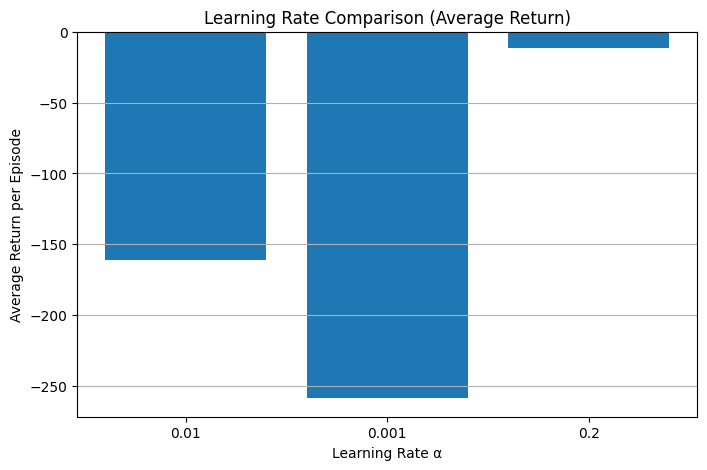

In [118]:
plt.figure(figsize=(8,5))

learning_rates = []
avg_returns = []

for lr in lr_results:
    learning_rates.append(str(lr))
    avg_returns.append(lr_results[lr]["avg_return"])

plt.bar(learning_rates, avg_returns)

plt.title("Learning Rate Comparison (Average Return)")
plt.xlabel("Learning Rate α")
plt.ylabel("Average Return per Episode")
plt.grid(axis='y')
plt.show()

### 9.1 Plot interpretation

This plot compares the average return per episode for 3 different learning rates

- α = 0.001 performs the worst with a very large negative return
- α = 0.01 performs better but still strugles as compared to the final one
a = 0.2 performs the best achieve the least negative average return


The Q-Learning update rule is:
Q(s,a) ← Q(s,a) + α [ r + γ max Q(s',a') − Q(s,a) ]

The α (learning rate) controls how aggressively the agent updates its value estimate.

A small α  means the updates are small, learning is slow and the agent takes many episodes to propagate the reward it gets backward

A moderate α means it'll learn faster than the small one but still slow in propagating value updates

A larger α in this scenario meant faster reward propagation and stronger updates toward the TD target and better convergence in fewer episodes

Conclusion:
We can conclude in this test the higher learning rate (0.2) was the best, allowing for faster convergence in the Taxi environment


## 10. Comparison Plots for Exploration (Fixed Learing Rate)

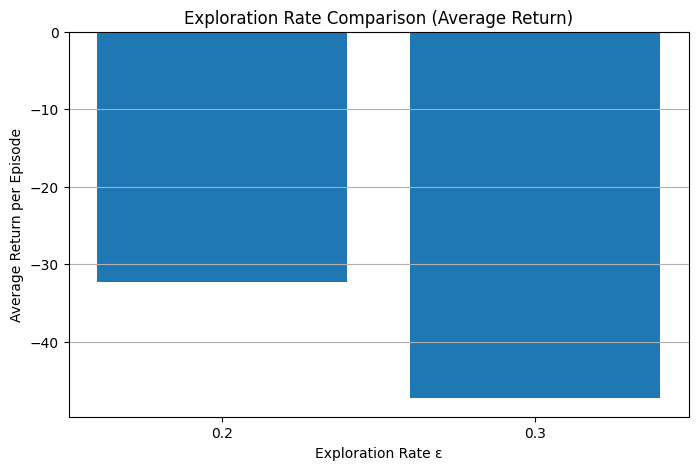

In [119]:
plt.figure(figsize=(8,5))

exploration_factors = []
avg_returns = []

for e in epsilon_results:
    exploration_factors.append(str(e))
    avg_returns.append(epsilon_results[e]["avg_return"])

plt.bar(exploration_factors, avg_returns)

plt.title("Exploration Rate Comparison (Average Return)")
plt.xlabel("Exploration Rate ε")
plt.ylabel("Average Return per Episode")
plt.grid(axis='y')

plt.show()

### 10.1  Plot Interpretation

This plot compares average return for different exploration rates (ε)

- ε = 0.2 performs better than ε = 0.3
- Higher exploration (0.3) in this case  leads to lower average return

Epsilon-Greedy policy

With probability ε > random action
With probability (1-ε)> greedy action

Higher ε increes the amount of exploration done

- ε = 0.3:
    Leads to more random actions, more illegal pickups/dropoffs incurring the penalty more. It may make much more unnecessary steps and it has slower convergence
- ε = 0.2:
    Still explores but less random than the higher value, more stable learning and has a higher average return


Conclusion:
Excessive exploration increases variance and reduces performance. Moderate exploration provides a better balance between exploration and exploitation

## 11. Best combination Selection

Based on:
- Convergence Speed
- Stability
- Average return

The best α & ε are chosen

ALPHA_0.01_EPS_0.2 -> Avg Return: -193.325, Avg Steps: 129.831
ALPHA_0.01_EPS_0.3 -> Avg Return: -237.366, Avg Steps: 133.221
ALPHA_0.001_EPS_0.2 -> Avg Return: -293.742, Avg Steps: 186.110
ALPHA_0.001_EPS_0.3 -> Avg Return: -348.658, Avg Steps: 187.256
ALPHA_0.2_EPS_0.2 -> Avg Return: -20.791, Avg Steps: 25.672
ALPHA_0.2_EPS_0.3 -> Avg Return: -33.185, Avg Steps: 28.733

===== Best Combination Found =====
Best Alpha: 0.2
Best Epsilon: 0.2
Best Average Return: -20.7908


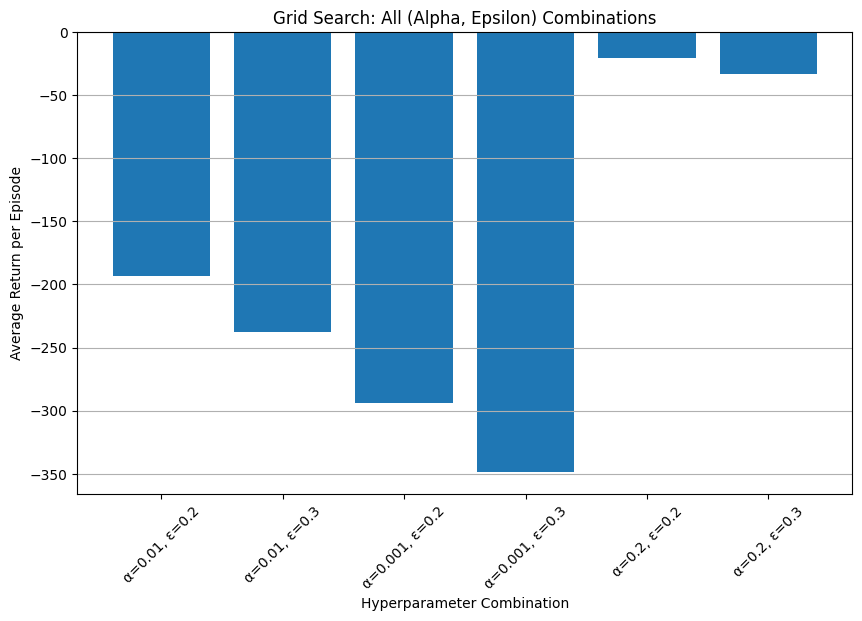


############################################################
EXPERIMENT: Best_Combination
Total Episodes: 5000
Average Return: -21.130
Average Steps: 25.892
############################################################



In [120]:
alpha_values = [0.01, 0.001, 0.2]
epsilon_values = [0.2, 0.3]

grid_results = {}

best_score = -float("inf")
best_alpha = None
best_epsilon = None

for alpha in alpha_values:
    for epsilon in epsilon_values:

        name = f"ALPHA_{alpha}_EPS_{epsilon}"

        Q, steps, rewards = train_q_learning(
            name=name,
            alpha=alpha,
            gamma=0.9,      #fixed gamma
            epsilon=epsilon,
            log_to_file=False
        )

        avg_return = np.mean(rewards)
        avg_steps = np.mean(steps)

        grid_results[(alpha, epsilon)] = {
            "avg_return": avg_return,
            "avg_steps": avg_steps
        }

        print(f"{name} -> Avg Return: {avg_return:.3f}, Avg Steps: {avg_steps:.3f}")

        #Track the best combination
        if avg_return > best_score:
            best_score = avg_return
            best_alpha = alpha
            best_epsilon = epsilon


# Plots of different combination
labels = []
avg_returns = []

for (alpha, epsilon), metrics in grid_results.items():
    labels.append(f"α={alpha}, ε={epsilon}")
    avg_returns.append(metrics["avg_return"])

plt.figure(figsize=(10,6))
plt.bar(labels, avg_returns)

plt.title("Grid Search: All (Alpha, Epsilon) Combinations")
plt.xlabel("Hyperparameter Combination")
plt.ylabel("Average Return per Episode")
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()


print("\n===== Best Combination Found =====")
print("Best Alpha:", best_alpha)
print("Best Epsilon:", best_epsilon)
print("Best Average Return:", best_score)




# ----- Retrain using the best combo -----

Q_best, steps_best, rewards_best = train_q_learning(
    name="Best_Combination",
    alpha=best_alpha,
    gamma=0.9,
    epsilon=best_epsilon,
    log_to_file=True
)


summarize_results("Best_Combination", steps_best, rewards_best)


### 11.1 Interpretation

This plot shows all the combinations of learning rate α and exploration rate ε

The combination of α = 0.2 and ε = 0.2 performs the best. Low α values consistently underperform across both ε values. Higher ε values worsens performance across the α values

Interaction insights:
- Low α + High ε:
    - It has slow updates combined with high randomness. It isn't the best at learning and it has the highest negative returns

- High α + High ε
    - Faster updates than the  Low α + High ε but has excessive exploration noise

- High α + Moderate  ε:
    - Fast learning, has balanced exploration not too random and has the best convergence behavior



Conclusion:
The best performing pair balances update strength and controlled exploration. The plot and grid search confirm that both learning rate and exploration rate set to 0.2 provide the highest average return out of the provided values.

## 12. Compare Base vs Best Plots

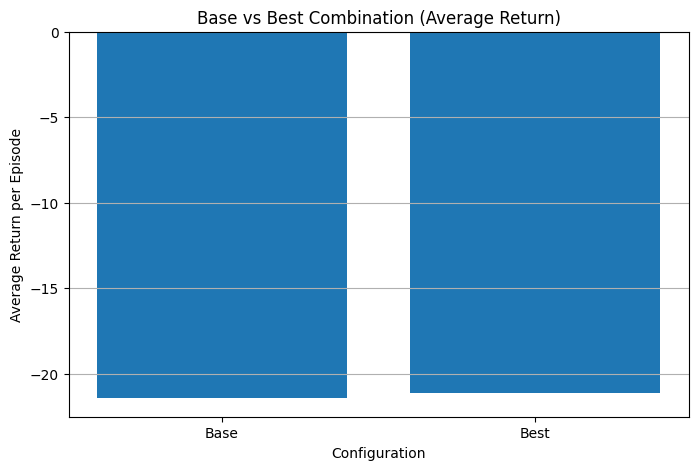

In [121]:
plt.figure(figsize=(8,5))

labels = ["Base", "Best"]
avg_returns = [
    np.mean(rewards_base),
    np.mean(rewards_best)
]

plt.bar(labels, avg_returns)

plt.title("Base vs Best Combination (Average Return)")
plt.xlabel("Configuration")
plt.ylabel("Average Return per Episode")
plt.grid(axis='y')

plt.show()

### 12.1 Plot interpretation

This plot compares the baseline hyperparameters with the best combination of hyperparameters based on the ones given.

- The best combination slightly outperforms the base defined hyperparameters
- Both achieve stable performance
- The opitmzied combination shows improved average return

Improvement comes from better hyperparameter tuning:
- Larger  α improves reward propagation speed
- Moderate ε improves exploration efficiency
- It is worth mentioning perhaps a way to have even better returns is to tune the discount factor to 0.98 or 0.95

The performance gain indicates that the hyperparameter interaction affects convergence behavior

Q-Learning convergence depends on sufficient exploration and stable update magnitude. The fine-tuned combination better satisfies the balance

Conclusion:
Hyperparameter fine tuning improves policy quality and convergence efficiency, validating the grid search approach.


### 12.2 Overall Findings

The experiments done demonstrate that Q-learning performance is sensitive to changes in learning rate and exploration rate

It was found that:
- Very small learning rates lead to slow convergence
- Expressive exploration increases variance and reduces return

The final selected hyperparameters maximize empirical average returns and provide stable convergence in the Taxi environment

## 13. Taxi Grid World Simulation

In [122]:

def play_agent(Q, episodes=50):

    env_render = gym.make("Taxi-v3", render_mode="human", max_episode_steps=None)


    sim_logger.info("\n" + "="*70)
    sim_logger.info("SIMULATION (Trained Greedy Policy)")
    sim_logger.info("="*70)

    for ep in range(episodes):

        state, _ = env_render.reset()
        done = False
        total_reward = 0
        step_count = 0

        sim_logger.info(f"\nEpisode {ep+1} START")

        while not done:
            env_render.render()
            time.sleep(0.3)

            action = np.argmax(Q[state])

            next_state, reward, terminated, truncated, _ = env_render.step(action)
            done = terminated or truncated

            sim_logger.info(
                f"Step {step_count+1:3d} | "
                f"State: {state:3d} | "
                f"Action: {action} | "
                f"Reward: {reward:4.1f}"
            )

            state = next_state
            total_reward += reward
            step_count += 1

        sim_logger.info(
            f"Episode {ep+1} END | "
            f"Total Steps: {step_count} | "
            f"Total Reward: {total_reward:.2f}"
        )

        print(f"Episode {ep+1} | Steps={step_count} | Reward={total_reward}")

    env_render.close()

play_agent(Q_best, episodes=50)

Episode 1 | Steps=14 | Reward=7
Episode 2 | Steps=13 | Reward=8
Episode 3 | Steps=18 | Reward=3
Episode 4 | Steps=15 | Reward=6
Episode 5 | Steps=10 | Reward=11
Episode 6 | Steps=12 | Reward=9
Episode 7 | Steps=15 | Reward=6
Episode 8 | Steps=7 | Reward=14
Episode 9 | Steps=17 | Reward=4
Episode 10 | Steps=14 | Reward=7
Episode 11 | Steps=15 | Reward=6
Episode 12 | Steps=13 | Reward=8
Episode 13 | Steps=14 | Reward=7
Episode 14 | Steps=15 | Reward=6
Episode 15 | Steps=16 | Reward=5
Episode 16 | Steps=17 | Reward=4
Episode 17 | Steps=14 | Reward=7
Episode 18 | Steps=13 | Reward=8
Episode 19 | Steps=15 | Reward=6
Episode 20 | Steps=17 | Reward=4
Episode 21 | Steps=14 | Reward=7
Episode 22 | Steps=15 | Reward=6
Episode 23 | Steps=12 | Reward=9
Episode 24 | Steps=16 | Reward=5
Episode 25 | Steps=13 | Reward=8
Episode 26 | Steps=11 | Reward=10
Episode 27 | Steps=13 | Reward=8
Episode 28 | Steps=14 | Reward=7
Episode 29 | Steps=16 | Reward=5
Episode 30 | Steps=15 | Reward=6
Episode 31 | Step

#### 13.1 Quick Simulation of Fist 10 Episodes of training

In [123]:
# def watch_training(alpha=0.1, gamma=0.9, epsilon=0, episodes=5):
#
#     env_watch = gym.make("Taxi-v3", render_mode="human")
#     state_size = env_watch.observation_space.n
#     action_size = env_watch.action_space.n
#
#     #Start with the empty Q-table
#     Q = np.zeros((state_size, action_size))
#
#     for ep in range(episodes):
#
#         state, _ = env_watch.reset()
#         done= False
#         total_reward = 0
#         steps = 0
#
#         print(f"\nEpisode {ep+1}  START")
#
#         while not done:
#
#             env_watch.render()
#             time.sleep(0.3)
#
#             # ε-greedy action selection
#             if random.uniform(0,1) < epsilon:
#                 action = env.action_space.sample()
#             else:
#                 action = np.argmax(Q[state])
#
#             next_state, reward, terminated, truncated, _ = env_watch.step(action)
#             done = terminated or truncated
#
#             #Q-learning update
#             Q[state, action] += alpha * (
#                 reward + gamma * np.max(Q[next_state]) - Q[state, action]
#
#             )
#
#             state = next_state
#             total_reward += reward
#             steps += 1
#
#         print(f"Episode {ep+1}  END | Steps={steps} | Reward={total_reward}" )
#
#     env_watch.close()
#
# watch_training(alpha=0.1, gamma=0.9, epsilon=0, episodes=5)


Episode 1  START


KeyboardInterrupt: 